# MUSA 650 Final: Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW

**Authors: Benjamin She, Eli Ericson**

In [1]:
import os, cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

from glob import glob
from matplotlib import colors
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output

2022-05-04 23:13:48.394482: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [37]:
## define params

BASEDIR = 'data'
CITIES = ['essen']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']
CLASSES = {
    0:'forest',
    1:'water',
    2:'agricultural',
    3:'urban_fabric',
    4:'grassland',
    5:'railway',
    6:'highway',
    7:'air_ship',
    8:'road',
    9:'building',
    10: 'other'}

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 1
NUM_CLASSES = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [28]:
# define segmentation mask color map and function to plot it
# very lightly adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

lcov_cmap = colors.ListedColormap(
    [
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
        "#f5f6f7",  # light gray for other
    ]
)
lcov_norm = colors.Normalize(vmin=0, vmax=10)

def seg2rgb(seg_map):
    """ Converts segmentation map to plottable RGB image. """
    return lcov_cmap(lcov_norm(np.squeeze(seg_map)))[:, :, :3]

## Image preprocessing

In [4]:
filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 264 - Masks: 264


In [ ]:
classSel = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5}

masks_recoded = np.zeros_like(arrMskS)

for k, v in classSel.items():
    masks_recoded[arrMskS == k] = v

show_img_mask(arrImgS, recode2cmap(masks_recoded), 4)

In [67]:
def read_image(dir):
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512,512))
    x = x.astype(np.uint8)
    return x

def read_mask(dir):
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512,512), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    recodes = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
    x_recoded = np.zeros_like(x)
    for k, v in recodes.items():
        x_recoded[x == k] = v
    return x_recoded

def show_img_mask(arrImg, arrMsk, i):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask']
    display_list = [arrImg[i,:,:,:],seg2rgb(arrMsk[i,:,:,:])]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
    plt.show()

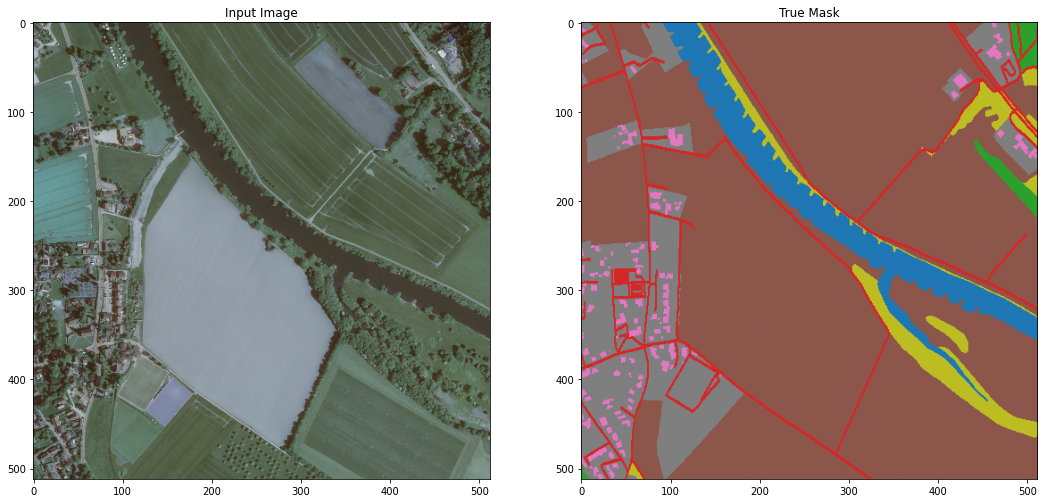

In [68]:
arrImg, arrMsk = [], []

for imgFile in filesImg:
    arrImg.append(read_image(imgFile))
for mskFile in filesMsk:
    arrMsk.append(read_mask(mskFile))

arrImg = np.asarray(arrImg)
arrMsk = np.asarray(arrMsk)

show_img_mask(arrImg, arrMsk, 4)

In [74]:
# split all images and masks into four as orthoimagery scale is too big

arrImgS, arrMskS = [], []

M = arrImg[0].shape[0]//2
N = arrImg[0].shape[1]//2

for im in arrImg:
    arrImgS.extend([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

for mk in arrMsk:
    arrMskS.extend([mk[x:x+M,y:y+N] for x in range(0,mk.shape[0],M) for y in range(0,mk.shape[1],N)])

arrImgS = np.asarray(arrImgS)
arrMskS = np.asarray(arrMskS)

In [75]:
def getMasksClasses(masklist, numClasses):
    '''returns a dict with the indices of masks sorted by the number of classes
    present in them'''
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

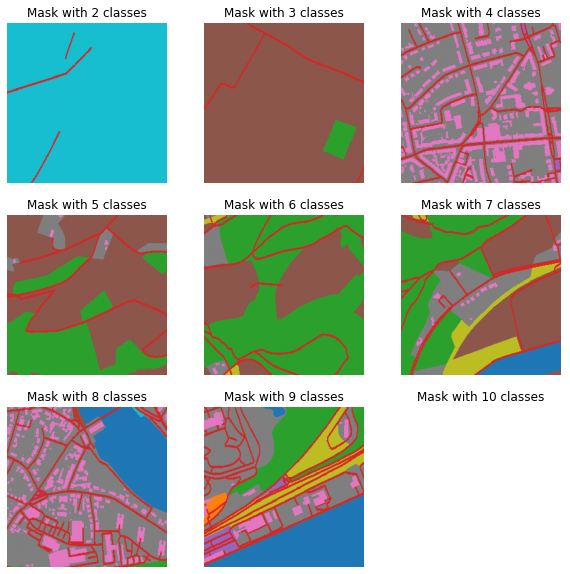

In [76]:
# get classes by masks
mskByClass = getMasksClasses(arrMskS, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i+1} classes')
  classMsk = arrMskS[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(arrMskS[mskByClass[i+1][np.random.randint(classMsk.shape[0])]]), vmin=0, vmax=NUM_CLASSES)

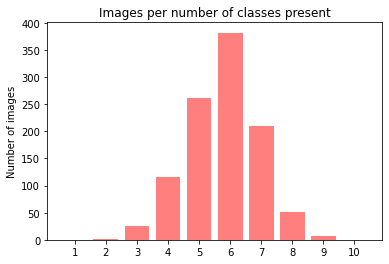

In [77]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

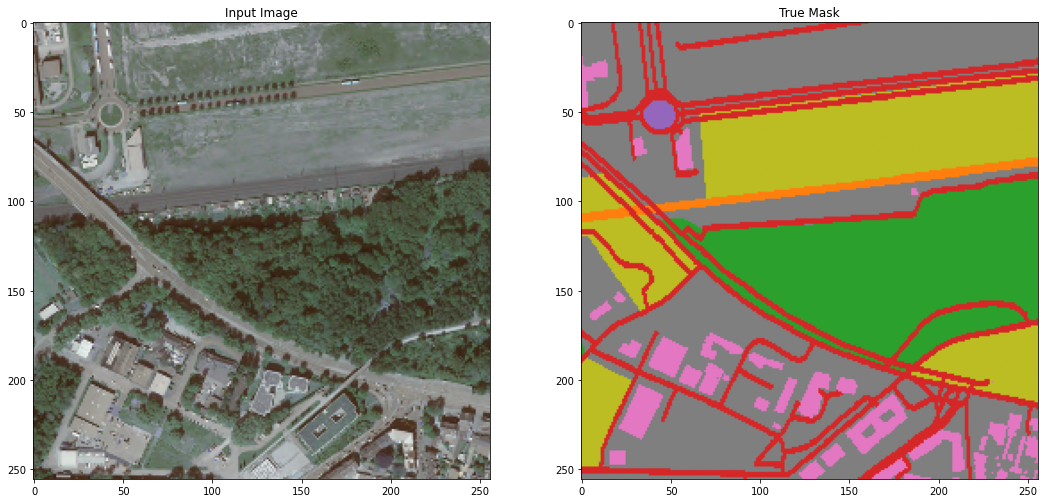

In [78]:
# get index of masks that contain railways, highways, airports/shipyards, and roads, and filter dataset to only those

ROWidxs = []
for i in range(len(arrMskS)):
    if True in np.in1d(arrMskS[i].flatten(),[6,7,8,9]):
        ROWidxs.append(i)

arrImgS = np.take(arrImgS,ROWidxs,axis=0)
arrMskS = np.take(arrMskS,ROWidxs,axis=0)

[len(arrImgS), len(ROWidxs)]

show_img_mask(arrImgS, arrMskS, 4)

In [80]:
def recode2cmap(masks_recoded):
    """Recodes reduced-class dataset to match color map for plotting."""
    
    map_dict = {0: 10, 1: 5, 2: 6, 3: 7, 4: 8}
    masks_recolored = np.zeros_like(masks_recoded)
    
    for k, v in map_dict.items():
        masks_recolored[masks_recoded == k] = v
        
    return masks_recolored

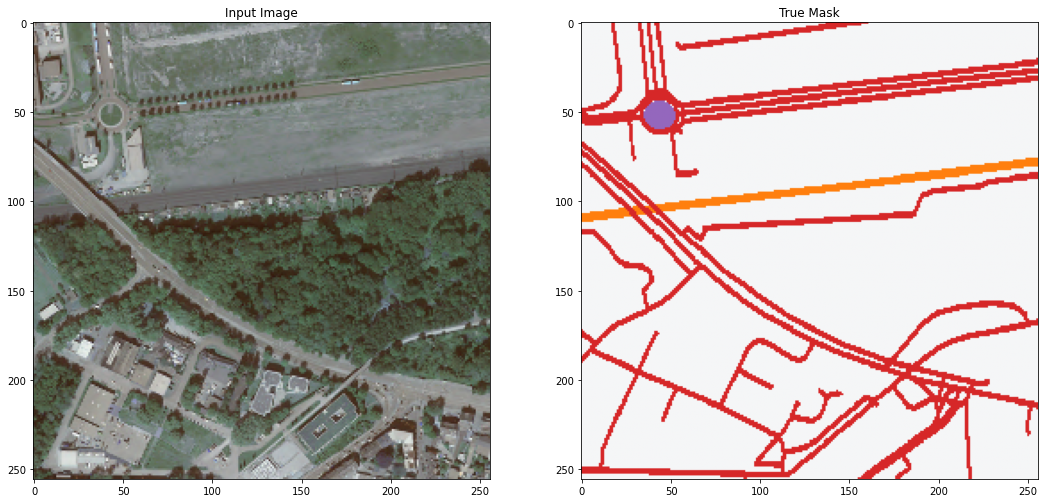

In [81]:
# reduce semantic classes to highways, roadways, railways, buildings, and all other

classSel = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 0}

masks_recoded = np.zeros_like(arrMskS)

for k, v in classSel.items():
    masks_recoded[arrMskS == k] = v

show_img_mask(arrImgS, recode2cmap(masks_recoded), 4)

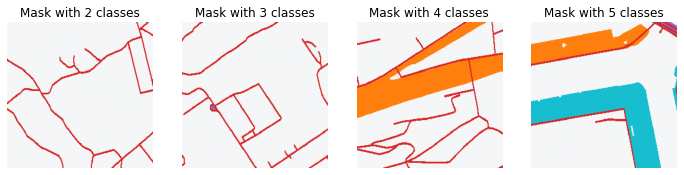

In [83]:
NUM_CLASSES_RED = len(np.unique(masks_recoded))

# get classes by masks
mskByClass = getMasksClasses(masks_recoded, NUM_CLASSES_RED)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12,3), nrows=1, ncols=4, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(0, NUM_CLASSES_RED):
  ax = axes.flatten()[i-1]
  ax.set_title(f'Mask with {i+1} classes')
  classMsk = masks_recoded[mskByClass[i+1]]
  if np.any(classMsk):
    ax.imshow(seg2rgb(recode2cmap(masks_recoded[mskByClass[i+1][np.random.randint(classMsk.shape[0])]])), 
              vmin=0, vmax=NUM_CLASSES)

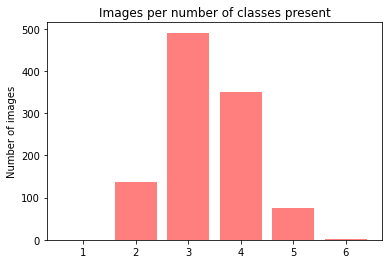

In [17]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES_RED+1)]

# plot bar
plt.bar(np.arange(1,NUM_CLASSES_RED+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(np.arange(1,NUM_CLASSES_RED+1))
plt.ylabel('Number of images')
plt.title("Images per number of classes present")
plt.show()

## CNN modeling (U-Net)

In [18]:
# geonrw = tf.data.Dataset.from_tensor_slices((arrImgS, arrMskS))
# geonrw = geonrw.shuffle(buffer_size=LEN_DATA)
# geonrw = geonrw.batch(BATCH_SIZE)
# geonrw = geonrw.prefetch(buffer_size=AUTOTUNE)

In [19]:
# dataset = {"train":geonrw.take(int(LEN_DATA / BATCH_SIZE * 0.7)),
#             "test":geonrw.skip(int(LEN_DATA / BATCH_SIZE * 0.7))}

In [88]:
# Split to train and test sets
X_tr, X_te, y_tr, y_te = train_test_split(
    arrImgS[0:100],
    arrMskS[0:100],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

In [89]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = MaxPooling2D(2)(f)
   p = Dropout(0.2)(p)
   return f, p

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def upsample_block(x, conv_features, n_filters):
   x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = concatenate([x, conv_features])
   x = Dropout(0)(x)
   x = double_conv_block(x, n_filters)
   return x

In [98]:
def build_unet():
    # inputs
    inputs = Input(shape=(INPUT_SHAPE))
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation = "softmax")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [99]:
model = build_unet()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_39[0][0]                  
______________________________________________________________________________________________

In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                    loss=SparseCategoricalCrossentropy(from_logits=True, 
                        reduction="auto",
                        name="categorical_crossentropy"),
                    metrics="accuracy",)

In [101]:
def display_sample(display_list):

    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

sample_image, sample_mask = (X_tr[1], y_tr[1])

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [102]:
NUM_EPOCHS = 20
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # to show samples after each epoch
    # DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=8, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model_history = model.fit(x =  X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 2.3731 - accuracy: 0.0872WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_test_batch_end` time: 0.0161s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 2.30970, saving model to best_model_unet.h5
80/80 [==============================] - 7s 93ms/step - loss: 2.3731 - accuracy: 0.0872 - val_loss: 2.3097 - val_accuracy: 0.1507
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 2.3328 - accuracy: 0.1276
Epoch 00002: val_loss improved from 2.30970 to 2.29239, saving model to best_model_unet.h5
80/80 [==============================] - 7s 91ms/step - loss: 2.3328 - accuracy: 0.1276 - val_loss: 2.2924 - val_accuracy: 0.1679
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 2.2850 - accuracy: 0.1757
Epoch 00003: val_loss improved from 2.29239 to 2.28031, saving model to best_model_unet.h5
80/80 [=========

### need to clean up everything below; used to check model output
seems the model with 'other' classes collapsed may be predicting 'other' for everything and still coming out with decent surface-level accuracy, since transportation classes are a minority of pixels?

model with all 10 classes still isn't good, but at least isn't outputting garbage

In [103]:
prediction = model(np.expand_dims(X_tr[0], 0)).numpy()
segmentation = np.argmax(prediction, axis=-1)

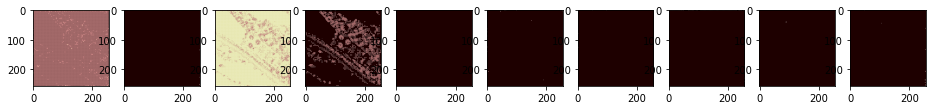

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=prediction.shape[-1], figsize=(16, 4))
for i, ax in enumerate(axs):
    ax.imshow(np.squeeze(prediction[..., i]), cmap='pink')

In [105]:
for i in range(5):
    min_ = np.min(prediction[..., i])
    max_ = np.max(prediction[..., i])
    mean = np.mean(prediction[..., i])
    std = np.std(prediction[..., i])
    print(f"Channel {i} min is {min_}, max is {max_}, mean is {mean}, std is {std}")

Channel 0 min is 0.0, max is 1.0, mean is 0.25767943263053894, std is 0.4365207552909851
Channel 1 min is 0.0, max is 0.12801635265350342, mean is 3.8825896808702964e-06, std is 0.0005628563230857253
Channel 2 min is 0.0, max is 1.0, mean is 0.7014015913009644, std is 0.4556943476200104
Channel 3 min is 0.0, max is 1.0, mean is 0.03954227641224861, std is 0.19210147857666016
Channel 4 min is 0.0, max is 0.995107889175415, mean is 2.399773438810371e-05, std is 0.004486133344471455


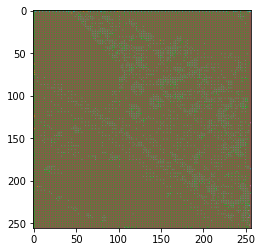

In [112]:
plt.imshow(seg2rgb(np.squeeze(segmentation)))

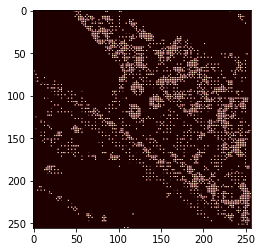

In [107]:
plt.imshow(np.squeeze(prediction[..., 3]), vmin=0, vmax=1, cmap='pink')

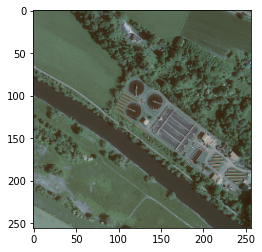

In [108]:
plt.imshow(X_tr[0])

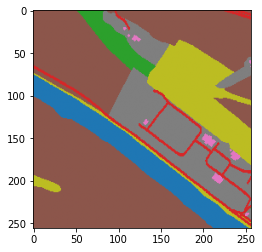

In [114]:
plt.imshow(seg2rgb(y_tr[0]))